# M V A Suhas Kumar
## EE17B109
### Programming Assignment 1


In [86]:
import numpy as np
import pandas as pd
import random as rd
import math
import matplotlib.pyplot as plt
import time 
import itertools
import warnings


## Generating Testbed true means

In [30]:
def test_bed_generator(Runs,arms,mean,var): #Runs is no of plays , arms are no of arms of bandit , mean  and variance are for  normal distribution  from  which q* is sampled for arms
    return  np.random.normal(mean,var,(Runs,arms)) # returns the true means of the bandit problems

## Epsilon Greedy algorithm
Here implimented algorithm parallely for all 2000 runs  to speed up the computation

In [66]:
def epsilon_greedy_parallel(k,steps,q_a,Runs,epsilon):
    Reward = np.zeros((Runs,steps)) # Array for finally capturing rewards at all steps and runs
    optimal_Action = np.zeros((Runs,steps)) #optimal action matrix
    Q_a = np.zeros((Runs,k)) # Initiating the estimated values for the  actions to zero
    n_a = np.zeros((Runs,k)) # No of times each action was selected
    for i in range(steps): #steps in each run
        A = np.random.uniform(0,1,(Runs,1)) <= epsilon # epsilon probability for selecting non greedy arm
        arm_t = np.multiply(A,np.random.randint(0,9,(Runs,1))) + np.multiply(np.invert(A).T,np.argmax(Q_a,axis=1)).T # selecting arm for all runs using parallel operations
        r_t = np.random.normal(q_a[range(Runs),arm_t.T],1) # reward obtained for all runs at time t
        n_a[range(Runs),arm_t.T] =  n_a[range(Runs),arm_t.T] + 1 # updating number of times arm selected
        Q_a[range(Runs),arm_t.T] += (1/n_a[range(Runs),arm_t.T])*(r_t - Q_a[range(Runs),arm_t.T]) # Average Reward
        Reward[:,i] = r_t
        optimal_Action[:,i] = arm_t.T==np.argmax(q_a,axis=1)
    return range(1,steps+1),np.mean(Reward,axis=0),100*np.mean(optimal_Action,axis=0) # returning values for plotting
        
        

        
        
        
        
    
    
    

Plotting Average reward and optimal action for different epsilon values

6.5113279819488525


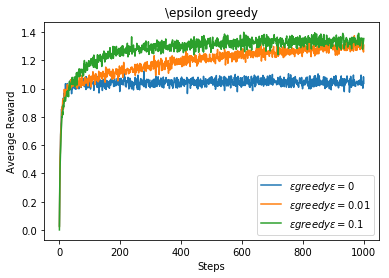

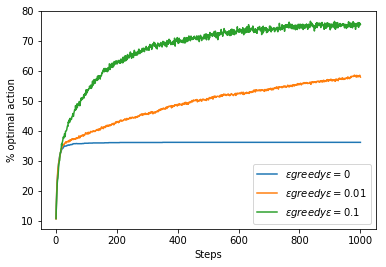

In [100]:
q_a = test_bed_generator(2000,10,0,1)
t1 = time.time()
for eps in [0,0.01,0.1]:
    a,b,c = epsilon_greedy_parallel(10,1000,q_a,2000,eps)
    plt.figure(0)
    plt.plot(a,b,label =r"$\epsilon greedy$"+r"$\epsilon = $" + str(eps))
    plt.xlabel("Steps")
    plt.title(r"\epsilon greedy")
    plt.ylabel("Average Reward")
    plt.legend(loc="best")
    plt.figure(1)
    plt.plot(a,c,label =r"$\epsilon greedy$"+r"$\epsilon = $" + str(eps))
    plt.xlabel("Steps")
    plt.ylabel("% optimal action")
    plt.legend(loc="best")
    
t2 = time.time()
print(t2-t1)

# Softmax Action Selection

Below are two helper functions for running softmax function

In [38]:
def return_arm_number(row): # for sampling from sofmax distribution with weights normalised using temp
    length = row.size
    return rd.choices(range(length),weights=row)[0]
def softmax(x,temp):
    expo = np.exp(x/temp)
    return expo/expo.sum()
    

In [68]:

def parallel_softmax_selection(k,steps,q_a,Runs,temperature):
    Reward = np.zeros((Runs,steps)) # Average reward for all runs and steps
    optimal_Action = np.zeros((Runs,steps)) #optimal action matrix
    #q_a = np.random.normal(mu,sigma,(Runs,k)) # sampling for obtaining means of arms
    Q_a = np.zeros((Runs,k)) # Initiating the estimated values for the  actions
    n_a = np.zeros((Runs,k)) # No of times each action was selected
    pi_a = np.ones((Runs,k)) * (1/k)
    for i in range(steps): #steps in each run
        arm_t = np.apply_along_axis(return_arm_number,1,pi_a) # sampling arm from softmax distribution
        r_t = np.random.normal(q_a[range(Runs),arm_t.T],1) # rewards at a timestep
        n_a[range(Runs),arm_t.T] =  n_a[range(Runs),arm_t.T] + 1 # updating no of times arms selected
        Q_a[range(Runs),arm_t.T] += (1/n_a[range(Runs),arm_t.T])*(r_t - Q_a[range(Runs),arm_t.T]) # Average Reward
        pi_a = np.apply_along_axis(softmax,1,Q_a,temperature) # softmaxing the estimated rewards
        Reward[:,i] = r_t
        optimal_Action[:,i] = arm_t.T==np.argmax(q_a,axis=1)
        

    return range(1,steps+1),np.mean(Reward,axis=0),100*np.mean(optimal_Action,axis=0)

Plotting the Average reward and optimal Action for different temparatures

128.50384140014648


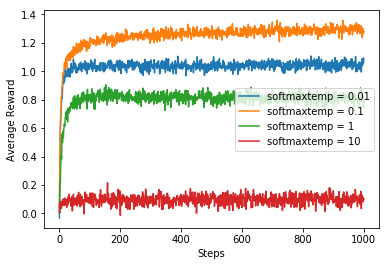

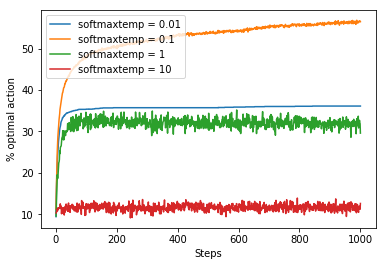

In [70]:
t1 = time.time()
q_a = test_bed_generator(2000,10,0,1)
for temp in [0.01,0.1,1,10]:
    a,b,c = parallel_softmax_selection(10,1000,q_a,2000,temp)
    plt.figure(0)
    plt.plot(a,b,label ="softmax" + "temp = "+ str(temp))
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend(loc="best")
    plt.figure(1)
    plt.plot(a,c,label ="softmax"+"temp = "+ str(temp))
    plt.xlabel("Steps")
    plt.ylabel("% optimal action")
    plt.legend(loc="best")
t2 = time.time()
print(t2-t1)

# UCB Algorithm

In [81]:
def UCB1_parallel(k,steps,q_a,Runs):
    mu , sigma = 0,1 # Normal distribution for sampling action values q(a) a=0,1....9
    Reward = np.zeros((Runs,steps)) # Average reward for all runs and steps
    optimal_Action = np.zeros((Runs,steps)) #optimal action matrix
    #q_a = np.random.normal(mu,sigma,(Runs,k)) # sampling for obtaining means of arms
    Q_a = np.zeros((Runs,k)) # Initiating the estimated values for the  actions
    n_a = np.zeros((Runs,k)) # No of times each action was selected
    for i in range(steps): #steps in each run
        arm_t = np.argmax(Q_a + np.sqrt(np.true_divide(np.full((Runs,k),2*np.log(i+1)),n_a)),axis=1) # selecting arm based on the rule
        r_t = np.random.normal(q_a[range(Runs),arm_t.T],1)  #reward obatineed
        n_a[range(Runs),arm_t.T] =  n_a[range(Runs),arm_t.T] + 1
        Q_a[range(Runs),arm_t.T] += (1/n_a[range(Runs),arm_t.T])*(r_t - Q_a[range(Runs),arm_t.T]) # Average Reward
        Reward[:,i] = r_t
        optimal_Action[:,i] = arm_t.T==np.argmax(q_a,axis=1)
    return range(1,steps+1),np.mean(Reward,axis=0),100*np.mean(optimal_Action,axis=0)
    
    

/home/suhas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/suhas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0, 0.5, '% optimal action')

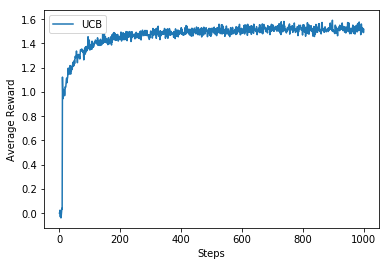

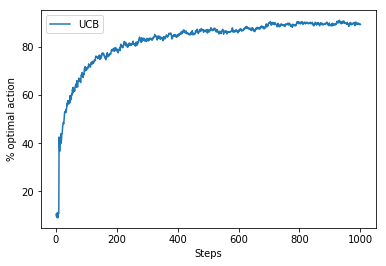

In [82]:
warnings.filterwarnings('ignore');
q_a = test_bed_generator(2000,10,0,1)
a,b,c = UCB1_parallel(10,1000,q_a,2000)
plt.figure(0)
plt.plot(a,b,label="UCB")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(loc="best")
plt.figure(1)
plt.plot(a,c,label="UCB")
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("% optimal action")



# Median Elimination Algorithm

In [75]:
def median_elimination(k,Runs,q_a,epsilon,delta):
    q_a = np.random.normal(0,1,(Runs,k))
    l = 1 
    epsilon_l = epsilon*0.25 # PAC Bounds
    delta_l = delta*0.5 # PAC bounds
    q_l = q_a
    k_l = k
    reward_each_step = []
    while k_l >1:             ###stopping condtion for MEA
        num_samples = (1/(epsilon_l/2)**2)*np.log(3/delta_l) # computing no of samples for lth run
        reward_l = np.zeros((Runs,k_l)) # reward matrix initiated
        for i in range(int(num_samples)):  # sampling all arms for no of samples calculated above
            reward_s = np.random.normal(q_l,1) # reward obtained for runs at the l th run
            reward_l += reward_s # summing for computing median with the reward
            for  l in list(np.mean(reward_s,axis=0)): # storing the obtained
                                                      #in step wise (This is done because all the arms are sampled at once 
                                                      #which is equivalent to k steps in other algos )
                reward_each_step.append(l)
        reward_l = reward_l/(int(num_samples))
        median_l = np.median(reward_l,1) # computed median
        arm_remaining = k_l - k_l//2 # No of arms remaining after lth step
        temp = np.zeros((Runs,arm_remaining)) # Creating a new q_a matrix for the remaining arms
        for j in range(Runs): #loop for the above
            m = 0
            for n in range(k_l):
                if reward_l[j][n] >= median_l[j]:
                    temp[j][m] = q_l[j][n]
                    m = m+1
        q_l = temp
        k_l = arm_remaining
        epsilon_l = 0.75 * epsilon_l # adjusting epsilon and de;ta
        delta_l = delta_l * 0.5
        l=l+1
    num_samples = (1/(epsilon_l/2)**2)*np.log(3/delta_l)
    reward_l = np.zeros((Runs,k_l))
    for i in range(int(num_samples)):  # final run when kl=1
        reward_s = np.random.normal(q_l,1)
        for  l in list(np.mean(reward_s,axis=0)):
                reward_each_step.append(l)
    print(reward_each_step[-1])
    return range(len(reward_each_step)),reward_each_step
                    
        
        
            
        

comparing for different epsilon and deltas

1.5281039834870231
1.5635274735468616
1.5526402833916746


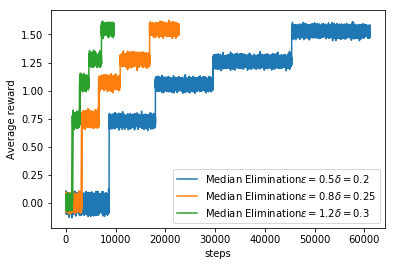

In [92]:
q_a = test_bed_generator(2000,10,0,1)
eps_delta = [[0.5,0.2],[0.8,0.25],[1.2,0.3]]
#eps_delta = [[1.2,0.3]]
for eps_del in eps_delta:
    a,b = median_elimination(10,2000,q_a,eps_del[0],eps_del[1])
    plt.figure(0)
    plt.plot(a,b,label="Median Elimination" + r"$\epsilon =$" + str(eps_del[0]) + r"$\delta =$" + str(eps_del[1]))
    plt.legend(loc="best")
    plt.ylabel("Average reward")
    plt.xlabel("steps")
    

# Plot comparing All 4 algos for 10 arm bandit Testbed

1.5279857269034811


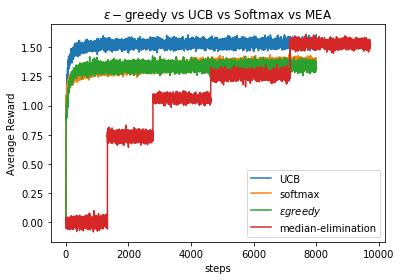

In [87]:
warnings.filterwarnings('ignore');
q_a = test_bed_generator(2000,10,0,1)
plt.figure(0)
a,b,c = UCB1_parallel(10,8000,q_a,2000)
plt.plot(a,b,label="UCB")
d,e,f = parallel_softmax_selection(10,8000,q_a,2000,0.1)
plt.plot(d,e,label="softmax")
g,h,i = epsilon_greedy_parallel(10,8000,q_a,2000,0.1)
plt.plot(g,h,label=r"$\epsilon greedy$")
j,k = median_elimination(10,2000,q_a,1.2,0.3)
plt.plot(j,k,label="median-elimination")
plt.title(r"$\epsilon -$" + "greedy vs UCB vs Softmax vs MEA")
plt.ylabel("Average Reward")
plt.xlabel("steps")
plt.legend(loc="best")
plt.show()




# Plot for MEA Algorithm for 1000 arms

3.256881427029637


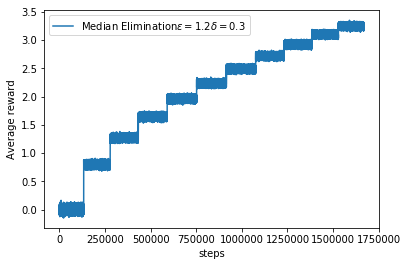

In [93]:
q_a = test_bed_generator(2000,10,0,1)
#eps_delta = [[0.5,0.2],[0.8,0.25],[1.2,0.3]]
eps_delta = [[1.2,0.3]]
for eps_del in eps_delta:
    a,b = median_elimination(1000,2000,q_a,eps_del[0],eps_del[1])
    plt.figure(0)
    plt.plot(a,b,label="Median Elimination" + r"$\epsilon =$" + str(eps_del[0]) + r"$\delta =$" + str(eps_del[1]))
    plt.legend(loc="best")
    plt.ylabel("Average reward")
    plt.xlabel("steps")

# Plot fot Epsilon Greedy vs Softmax vs UCB for 1000arm and 1000 steps

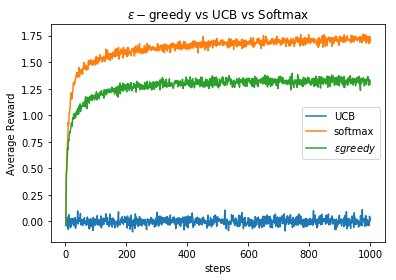

In [99]:
warnings.filterwarnings('ignore');
q_a = test_bed_generator(2000,1000,0,1)
plt.figure(0)
a,b,c = UCB1_parallel(1000,1000,q_a,2000)
plt.plot(a,b,label="UCB")
d,e,f = parallel_softmax_selection(1000,1000,q_a,2000,0.1)
plt.plot(d,e,label="softmax")
g,h,i = epsilon_greedy_parallel(1000,1000,q_a,2000,0.1)
plt.plot(g,h,label=r"$\epsilon greedy$")
plt.title(r"$\epsilon -$" + "greedy vs UCB vs Softmax")
plt.ylabel("Average Reward")
plt.xlabel("steps")
plt.legend(loc="best")





# Plot fot Epsilon Greedy vs Softmax vs UCB for 1000arm and 10000 steps

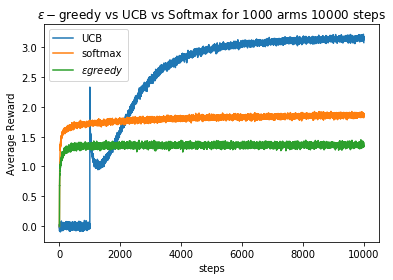

In [96]:
warnings.filterwarnings('ignore');
q_a = test_bed_generator(2000,1000,0,1)
plt.figure(0)
a,b,c = UCB1_parallel(1000,10000,q_a,2000)
plt.plot(a,b,label="UCB")
d,e,f = parallel_softmax_selection(1000,10000,q_a,2000,0.1)
plt.plot(d,e,label="softmax")
g,h,i = epsilon_greedy_parallel(1000,10000,q_a,2000,0.1)
plt.plot(g,h,label=r"$\epsilon greedy$")
plt.title(r"$\epsilon -$" + "greedy vs UCB vs Softmax for 1000 arms 10000 steps")
plt.ylabel("Average Reward")
plt.xlabel("steps")
plt.legend(loc="best")
plt.show()